# **SETUP AND IMPORTS** 
NOTE: you might need to run the notebook twice, to resolve dependency issues (run all, restart session, run all)

In [1]:
!pip install --upgrade numpy pandas torch stable-baselines3 sb3-contrib gymnasium pettingzoo matplotlib seaborn
!pip install famnit_gym@git+https://github.com/DomenSoberlFamnit/famnit-gym

  Using cached pettingzoo-1.25.0-py3-none-any.whl.metadata (8.9 kB)
Using cached pettingzoo-1.25.0-py3-none-any.whl (852 kB)
  Attempting uninstall: pettingzoo
    Found existing installation: pettingzoo 1.24.3
    Uninstalling pettingzoo-1.24.3:
      Successfully uninstalled pettingzoo-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
famnit-gym 0.1 requires pettingzoo==1.24.3, but you have pettingzoo 1.25.0 which is incompatible.
kaggle-environments 1.18.0 requires gymnasium==0.29.0, but you have gymnasium 1.2.3 which is incompatible.
kaggle-environments 1.18.0 requires pettingzoo==1.24.0, but you have pettingzoo 1.25.0 which is incompatible.
kaggle-environments 1.18.0 requires stable-baselines3==2.1.0, but you have stable-baselines3 2.7.1 which is incompatible.
  Cloning https://github.com/DomenSoberlFamnit/famnit-gym to /tmp/pip-install-9suo8d9q/famni

In [2]:
# GENERAL
import os
import time
import random
import numpy as np
import pandas as pd

# RL FRAMEWORK
import torch
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker

# ENVIRONMENT
import gymnasium as gym
import pettingzoo.utils.wrappers as pz_wrappers
from famnit_gym.envs.mill.mill_env import MillEnv
from famnit_gym.envs.mill import mill_model as mill

# VISUALIZATIONS
import matplotlib.pyplot as plt
import seaborn as sns


# DUE TO SPARSE LEGAL MOVES THE PROBABILITIES DO NOT EXACTLY ADD UP -
# THIS CAUSES ERROR, WITH THIS COMMAND WE SUPPRESS IT
torch.distributions.Distribution.set_default_validate_args(False)

2026-01-11 15:29:54.170705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768145394.193863     268 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768145394.201454     268 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768145394.221940     268 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768145394.221960     268 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768145394.221963     268 computation_placer.cc:177] computation placer alr

# **CONSTANTS**

In [3]:
# GENERAL FOR THE MILL GAME AND ENVIRONMENT
INF = 200
BOARD_SIZE = 24
MAX_POS = 25
ACTION_SIZE = MAX_POS ** 3
OBS_SIZE = BOARD_SIZE + 6

# RL MODEL + EVALUATION SPECIFIC
N_STEPS = 512
N_GAMES = 1000

# **MINIMAX AGENT**

In [4]:
# COPIED FROM THE SEMINAR 1 WORK -
# MINIMAX WITH ALPHA-BETA PRUNING, LIMITED DEPTH AND MOVE ORDERING
# AGENTS BASED ON IT WITH VARIOUS DIFFICULTIES

def evaluate_state(current_state, maximizing_player):
    opponent = 3 - maximizing_player
    p1_pieces = current_state.count_pieces(maximizing_player)
    p2_pieces = current_state.count_pieces(opponent)
    piece_advantage = (p1_pieces - p2_pieces) * 30
    position_advantage = evaluate_positions(current_state, maximizing_player, opponent)
    evaluated_score = piece_advantage + position_advantage
    normalized_score = evaluated_score / 240
    return normalized_score


def evaluate_positions(current_state, current_player, opponent):
    evaluated_score = 0
    board_state = current_state.get_state()

    position_values = {
        4: 4, 5: 4, 6: 4, 14: 4, 21: 4, 20: 4, 19: 4, 11: 4,
        1: 3, 2: 3, 3: 3, 15: 3, 24: 3, 23: 3, 22: 3, 10: 3,
        7: 3, 8: 3, 9: 3, 13: 3, 18: 3, 17: 3, 16: 3, 12: 3
    }

    for pos, value in position_values.items():
        if board_state[pos - 1] == current_player:
            evaluated_score += value
        elif board_state[pos - 1] == opponent:
            evaluated_score -= value

    return evaluated_score


def order_moves(current_state, current_player, maximizing_player, unordered_moves):
    move_scores = []
    maximizing = True if current_player == maximizing_player else False

    for move in unordered_moves:
        cloned_state = current_state.clone()
        cloned_state.make_move(current_player, move)
        score = evaluate_state(cloned_state, maximizing_player)
        move_scores.append((move, score))

    move_scores.sort(key=lambda x: x[1], reverse=maximizing)
    return [move for move, score in move_scores]


def minimax(current_state, current_player, maximizing_player, state_depth, max_depth, moves_counter, alpha, beta):
    if state_depth == 200 - moves_counter:
        return 0

    maximizing = True if current_player == maximizing_player else False
    terminal_reward = INF - state_depth

    if current_state.game_over():
        return -terminal_reward if maximizing else terminal_reward

    if state_depth == max_depth:
        return evaluate_state(current_state, maximizing_player)

    legal_moves = current_state.legal_moves(current_player)

    ordered_moves = order_moves(current_state, current_player, maximizing_player, legal_moves)

    final_score = -INF if maximizing else INF

    for move in ordered_moves:
        next_state = current_state.clone()
        next_state.make_move(current_player, move)

        score = minimax(next_state, 3 - current_player, maximizing_player,
                        state_depth + 1, max_depth, moves_counter, alpha, beta)

        if maximizing:
            final_score = max(final_score, score)
            alpha = max(alpha, final_score)
        else:
            final_score = min(final_score, score)
            beta = min(beta, final_score)

        if alpha >= beta:
            break

    return final_score


def find_optimal_move(current_state, maximizing_player, max_depth, moves_counter):
    best_score, optimal_move = -INF, None
    legal_moves = current_state.legal_moves(maximizing_player)
    ordered_moves = order_moves(current_state, maximizing_player, maximizing_player, legal_moves)

    for move in ordered_moves:
        next_state = current_state.clone()
        next_state.make_move(maximizing_player, move)

        score = minimax(next_state, 3 - maximizing_player, maximizing_player,
                        1, max_depth, moves_counter, best_score, INF)

        if score > best_score:
            best_score, optimal_move = score, move

    return optimal_move

# SINCE THE AGENTS WITH BIGGER DEPTH TAKE EXPONENTIALLY MORE TIME TO COMPUTE A MOVE,
# WE LIMITED US TO MAX_DEPTH=3 AND ALSO PLAYED WITH THE RANDOMNESS
class AiPlayerWithDifficulty:
    MAX_DEPTH_SETTINGS = {
        "apprentice": 1, "adventurer": 2, "knight": 3
    }
    NUM_RANDOM_MOVES_SETTINGS = {
        "apprentice": 0.5, "adventurer": 0.5, "knight": 0.5
    }

    def __init__(self, player_id, difficulty):
        self.player_id = player_id
        self.difficulty = difficulty

    def get_max_depth(self):
        return self.MAX_DEPTH_SETTINGS[self.difficulty]

    def get_num_random_moves(self):
        return self.NUM_RANDOM_MOVES_SETTINGS[self.difficulty]

    def choose_move(self, current_state, num_moves_already_done):
        max_depth = self.get_max_depth()
        num_random_moves = self.get_num_random_moves()

        legal_moves = current_state.legal_moves(self.player_id)

        if random.random() < num_random_moves:
              return random.choice(legal_moves)

        return find_optimal_move(current_state, self.player_id, max_depth, num_moves_already_done)


# **WRAPPERS FOR ORIGINAL MILL ENVIRONMENT COMPATIBILITY WITH SB3**

In [5]:
# WRAPPER CLASS TO ADAPT PETTINGZOO MILL ENVIRONMENT FOR STABLE-BASELINES3 (SB3)
# THIS WRAPPER CONVERTS THE NATIVE MULTI-AGENT ENVIRONMENT INTO A SINGLE-AGENT FORMAT
# COMPATIBLE WITH SB3'S MASKABLEPPO
class MillSB3Wrapper(pz_wrappers.BaseWrapper):
    def __init__(self, env):
        super().__init__(env)

        # DEFINE OBSERVATION SPACE FOR EACH AGENT AS A DICTIONARY CONTAINING:
        # - "observation": NORMALIZED BOARD STATE + GAME FEATURES (FLOAT32)
        # - "action_mask": BINARY MASK INDICATING LEGAL MOVES (INT8)
        self.observation_spaces = {
            agent: gym.spaces.Dict({
                "observation": gym.spaces.Box(low=-1, high=25, shape=(OBS_SIZE,), dtype=np.float32),
                "action_mask": gym.spaces.Box(low=0, high=1, shape=(ACTION_SIZE,), dtype=np.int8)
            }) for agent in self.possible_agents
        }

        # DEFINE ACTION SPACE AS A SINGLE DISCRETE INTEGER (0 TO ACTION_SIZE-1)
        # ENCODED FROM SOURCE, DESTINATION, AND REMOVAL POSITIONS
        self.action_spaces = {
            agent: gym.spaces.Discrete(ACTION_SIZE) for agent in self.possible_agents
        }

    # RESET THE ENVIRONMENT AND PROPAGATE SEED/OPTIONS
    def reset(self, seed=None, options=None):
        self.env.reset(seed=seed, options=options)

    # RETURN OBSERVATION SPACE FOR A GIVEN AGENT
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    # RETURN ACTION SPACE FOR A GIVEN AGENT
    def action_space(self, agent):
        return self.action_spaces[agent]

    # ENCODE A 3D ACTION ARRAY [SRC, DST, TAKE] INTO A SINGLE INTEGER FOR SB3
    def _encode_action(self, action_array):
        src, dst, take = action_array
        return src * (MAX_POS ** 2) + dst * MAX_POS + take

    # DECODE A SINGLE INTEGER ACTION BACK INTO 3D ARRAY [SRC, DST, TAKE]
    def _decode_action(self, action_int):
        coords = np.unravel_index(action_int, (MAX_POS, MAX_POS, MAX_POS))
        return np.array(coords, dtype=np.int8)

    # EXECUTE AN ACTION BY DECODING IT AND PASSING TO THE UNDERLYING ENVIRONMENT
    def step(self, action):
        decoded_action = self._decode_action(action)
        return self.env.step(decoded_action)

    # OBSERVE THE CURRENT STATE FOR A SPECIFIC AGENT
    # RETURNS A DICT WITH NORMALIZED OBSERVATION AND ACTION MASK
    def observe(self, agent):
        raw_board = self.env.observe(agent)
        agent_idx = self.env.agent_index[agent]

        # NORMALIZE BOARD: 1.0 FOR OWN PIECES, -1.0 FOR OPPONENT, 0.0 FOR EMPTY
        # (easy to revert perspective - jsut take negation)
        board = np.zeros_like(raw_board, dtype=np.float32)
        if agent_idx == 1:
            board[raw_board == 1] = 1.0
            board[raw_board == 2] = -1.0
        else:
            board[raw_board == 2] = 1.0
            board[raw_board == 1] = -1.0

        # COUNT PIECES ON BOARD FOR BOTH PLAYERS
        my_pieces_on_board = np.sum(board == 1)
        opp_pieces_on_board = np.sum(board == -1)

        # EXTRACT PIECES REMAINING TO PLACE FROM ENVIRONMENT OR MODEL
        model_ref = getattr(self.env, "_model", None)
        p_to_place = getattr(self.env, "pieces_to_place", getattr(model_ref, "pieces_to_place", {}))
        opp_agent = self.env._get_opponent(agent)

        my_pieces_to_place = p_to_place.get(agent, 0)
        opp_pieces_to_place = p_to_place.get(opp_agent, 0)

        # MAP PHASE STRING TO NUMERICAL VALUE (PLACING=0, MOVING=1, FLYING=2)
        phase_map = {'placing': 0.0, 'moving': 1.0, 'flying': 2.0}
        agent_phase_str = self.env.infos[agent].get('phase')
        phase = phase_map.get(agent_phase_str, -1.0)

        # GET CURRENT TURN NUMBER (NORMALIZED TO [0,1])
        turn_num = getattr(self.env, "num_moves", 0)

        # CONSTRUCT ADDITIONAL GAME FEATURES (NORMALIZED)
        features = np.array([
            my_pieces_on_board / 9.0, opp_pieces_on_board / 9.0,
            my_pieces_to_place / 9.0, opp_pieces_to_place / 9.0,
            phase, turn_num / 200.0
        ], dtype=np.float32)

        # COMBINE BOARD STATE WITH FEATURES
        enhanced_obs = np.concatenate([board, features])

        # BUILD ACTION MASK: 1 FOR LEGAL MOVES, 0 OTHERWISE
        mask = np.zeros(ACTION_SIZE, dtype=np.int8)
        if agent == self.env.agent_selection:
            legal_moves = self.env.legal_moves.get(agent, [])
            for move in legal_moves:
                encoded = self._encode_action(move)
                mask[encoded] = 1

        return {"observation": enhanced_obs, "action_mask": mask}


# SECOND WRAPPER TO EXTRACT ONLY THE OBSERVATION PART FOR SB3'S EXPECTED INTERFACE
class SB3ActionMaskWrapper(pz_wrappers.BaseWrapper, gym.Env):
    def __init__(self, env):
        super().__init__(env)

        # EXTRACT OBSERVATION SPACE FROM THE DICT SPACE OF THE WRAPPED ENV
        full_space = self.env.observation_space(self.possible_agents[0])
        self.observation_space = full_space["observation"]

        # USE THE ACTION SPACE OF THE FIRST AGENT (ALL AGENTS HAVE SAME SPACE)
        self.action_space = self.env.action_space(self.possible_agents[0])
        self.metadata = getattr(env, "metadata", {"render_modes": []})
        self.reward_range = getattr(env, "reward_range", (-float("inf"), float("inf")))
        self.spec = getattr(env, "spec", None)

    # RESET AND RETURN OBSERVATION FOR THE CURRENT AGENT
    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        return self.observe(self.agent_selection), {}

    # EXECUTE ACTION AND RETURN NEXT OBSERVATION, REWARD, DONE, INFO
    # NOTE: REWARD IS CUMULATIVE AND TERMINATION/TRUNCATION ARE TAKEN FROM CURRENT AGENT
    def step(self, action):
        current_agent = self.agent_selection
        super().step(action)
        next_agent = self.agent_selection
        return (
            self.observe(next_agent),
            self._cumulative_rewards[current_agent],
            self.terminations[current_agent],
            self.truncations[current_agent],
            self.infos[current_agent],
        )

    # EXTRACT ONLY THE OBSERVATION FROM THE DICT RETURNED BY THE WRAPPED ENV
    def observe(self, agent):
        return self.env.observe(agent)["observation"]

    # RETURN ACTION MASK FOR THE CURRENT AGENT
    def action_mask(self):
        return self.env.observe(self.agent_selection)["action_mask"]


# WRAPPER TO HANDLE OPPONENT PLAY DURING TRAINING/EVALUATION
# AUTOMATICALLY PLAYS OPPONENT MOVES SO THE RL AGENT ONLY SEES ITS OWN TURNS
class OpponentWrapper(gym.Wrapper):
    def __init__(self, env, opponent_model=None, opponent_type="random", difficulty="apprentice", epsilon=0.1):
        super().__init__(env)
        self.opponent_model = opponent_model      # MODEL FOR SELF-PLAY OR OTHER RL AGENT
        self.opponent_type = opponent_type        # "random", "self-play", or "minimax"
        self.epsilon = epsilon                    # EXPLORATION RATE FOR SELF-PLAY
        self.training_agent_idx = 1               # INDEX OF THE AGENT BEING TRAINED (PLAYER_2)
        self.turns = 0                            # TRACK NUMBER OF TURNS

        # INITIALIZE MINIMAX AGENT IF OPPONENT TYPE IS MINIMAX
        if opponent_type == "minimax":
            self.opponent_ai = AiPlayerWithDifficulty(player_id=1, difficulty=difficulty)

    # FORWARD ACTION MASK REQUEST TO WRAPPED ENV
    def action_mask(self):
        return self.env.action_mask()

    # RESET ENVIRONMENT AND PLAY OPPONENT MOVES UNTIL TRAINING AGENT'S TURN
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.turns = 0
        while self._current_agent_idx() != self.training_agent_idx:
            obs = self._play_opponent_move()
            if self.env.unwrapped.terminations[self.env.unwrapped.agent_selection]:
                break
        return obs, info

    # STEP WITH TRAINING AGENT'S ACTION, THEN PLAY OPPONENT MOVES UNTIL NEXT TRAINING TURN
    def step(self, action):
        obs, reward, done, trunc, info = self.env.step(action)
        self.turns += 1

        while not (done or trunc) and self._current_agent_idx() != self.training_agent_idx:
            obs = self._play_opponent_move()
            self.turns += 1

            # UPDATE REWARD AND TERMINATION INFO FROM THE TRAINING AGENT'S PERSPECTIVE
            current = self.env.unwrapped.possible_agents[self.training_agent_idx]
            reward = self.env.unwrapped._cumulative_rewards[current]
            done = self.env.unwrapped.terminations[current]
            trunc = self.env.unwrapped.truncations[current]
            if done or trunc:
                break

        return obs, reward, done, trunc, info

    # GET INDEX OF CURRENT AGENT IN THE LIST OF POSSIBLE AGENTS
    def _current_agent_idx(self):
        return self.env.unwrapped.possible_agents.index(self.env.unwrapped.agent_selection)

    # PLAY A SINGLE OPPONENT MOVE BASED ON OPPONENT TYPE
    def _play_opponent_move(self):
        obs = self.env.observe(self.env.unwrapped.agent_selection)
        mask = self.env.action_mask()

        # RANDOM OPPONENT OR SELF-PLAY WITH NO MODEL (FALLBACK TO RANDOM)
        if self.opponent_type == "random" or (self.opponent_model is None and self.opponent_type == "self-play"):
            valid_actions = np.where(mask == 1)[0]
            action = np.random.choice(valid_actions) if len(valid_actions) > 0 else 0

        # SELF-PLAY: USE RL MODEL WITH EPSILON-GREEDY EXPLORATION
        elif self.opponent_type == "self-play":
            if np.random.random() < self.epsilon:
                valid_actions = np.where(mask == 1)[0]
                action = np.random.choice(valid_actions) if len(valid_actions) > 0 else 0
            else:
                with torch.no_grad():
                    action, _ = self.opponent_model.predict(obs, action_masks=mask, deterministic=False)
                    action = int(action)

        # MINIMAX OPPONENT: USE ALPHA-BETA SEARCH AGENT
        elif self.opponent_type == "minimax":
            base_logic = self.env.unwrapped
            state = base_logic._model  # ACCESS INTERNAL GAME STATE
            act_array = self.opponent_ai.choose_move(state, self.turns)

            # FIND THE WRAPPER THAT HAS _encode_action METHOD
            encoder = self.env
            while not hasattr(encoder, "_encode_action") and hasattr(encoder, "env"):
                encoder = encoder.env
            action = encoder.__getattribute__("_encode_action")(act_array)

        # EXECUTE THE CHOSEN ACTION AND RETURN NEW OBSERVATION
        self.env.step(action)
        return self.env.observe(self.env.unwrapped.agent_selection)

In [6]:
# FUNCTION TO RETRIEVE ACTION MASK FROM ENVIRONMENT - REQUIRED BY SB3's ActionMasker WRAPPER
# THIS FUNCTION IS PASSED AS A CALLBACK TO THE ActionMasker TO DYNAMICALLY GET VALID ACTIONS
def mask_fn(env):
    return env.action_mask()

# FACTORY FUNCTION TO CREATE AND CONFIGURE THE MILL ENVIRONMENT
def create_env(render_mode=None):
    internal_env = MillEnv(render_mode=render_mode)
    wrapped_env = MillSB3Wrapper(internal_env)
    wrapped_env = pz_wrappers.AssertOutOfBoundsWrapper(wrapped_env)
    wrapped_env = pz_wrappers.OrderEnforcingWrapper(wrapped_env)
    return wrapped_env

# FUNCTION TO CREATE AND CONFIGURE THE PPO (PROXIMAL POLICY OPTIMIZATION) MODEL
# PARAMETERS:
def create_model(env, seed=None):
    # INITIALIZE MASKABLEPPO MODEL - EXTENSION OF STANDARD PPO THAT SUPPORTS ACTION MASKING
    # ACTION MASKING IS CRITICAL FOR MILL GAME TO PREVENT ILLEGAL MOVES
    model = MaskablePPO(
        # POLICY ARCHITECTURE: MASKABLE VERSION OF ACTOR-CRITIC
        MaskableActorCriticPolicy,

        # ENVIRONMENT INSTANCE
        env,

        # VERBOSITY LEVEL: 1 = PRINT TRAINING PROGRESS
        verbose=1,

        # LEARNING RATE: 0.0003 - BALANCES CONVERGENCE SPEED AND STABILITY
        # TYPICAL VALUE FOR PPO, SMALL ENOUGH FOR STABLE UPDATES, LARGE ENOUGH FOR REASONABLE TRAINING TIME
        learning_rate=3e-4,

        # NUMBER OF STEPS TO COLLECT PER POLICY UPDATE (N_STEPS FROM CONSTANTS)
        # LARGER VALUES PROVIDE MORE DATA FOR EACH UPDATE BUT SLOWER TRAINING
        n_steps=N_STEPS,

        # BATCH SIZE: 64 - NUMBER OF SAMPLES USED FOR EACH GRADIENT UPDATE
        # BALANCES MEMORY USAGE AND UPDATE QUALITY (TYPICAL FOR MILL GAME'S ACTION SPACE)
        batch_size=64,

        # NUMBER OF EPOCHS TO OPTIMIZE THE SURROGATE LOSS: 3
        # TYPICAL PPO VALUE, PERFORMS MULTIPLE UPDATES ON THE SAME DATA FOR BETTER SAMPLE EFFICIENCY
        n_epochs=3,

        # DISCOUNT FACTOR (GAMMA): 0.99 - HOW MUCH FUTURE REWARDS ARE VALUED
        # HIGH VALUE (CLOSE TO 1) MEANS AGENT PLANS LONG-TERM, APPROPRIATE FOR STRATEGIC GAMES LIKE MILL
        gamma=0.99,

        # GAE (GENERALIZED ADVANTAGE ESTIMATION) LAMBDA: 0.95
        # TRADEOFF BETWEEN BIAS AND VARIANCE IN ADVANTAGE ESTIMATION
        # 0.95 IS STANDARD FOR BALANCED PERFORMANCE
        gae_lambda=0.95,

        # ENTROPY COEFFICIENT: 0.01 - ENCOURAGES EXPLORATION BY REWARDING ACTION DIVERSITY
        # PREVENTS PREMATURE CONVERGENCE TO SUBOPTIMAL POLICIES
        # SMALL VALUE TO AVOID EXCESSIVE RANDOMNESS IN LATER TRAINING
        ent_coef=0.01,

        # CLIP RANGE: 0.2 - PPO'S TRUST REGION PARAMETER
        # LIMITS HOW MUCH THE POLICY CAN CHANGE PER UPDATE FOR STABLE TRAINING
        # STANDARD PPO VALUE, PREVENTS DESTRUCTIVELY LARGE POLICY UPDATES
        clip_range=0.2,

        # MAXIMUM GRADIENT NORM: 0.5 - GRADIENT CLIPPING THRESHOLD
        # PREVENTS EXPLODING GRADIENTS, STABILIZES TRAINING
        # CONSERVATIVE VALUE FOR STABILITY
        max_grad_norm=0.5,

        # POLICY NETWORK ARCHITECTURE: TWO HIDDEN LAYERS WITH 256 NEURONS EACH
        # SEPARATE NETWORKS FOR POLICY (pi) AND VALUE (vf) FUNCTIONS
        # (it was the most balanced we came up with, the default activation
        # function in SB3 is tanh)
        policy_kwargs=dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]),

        # DEVICE SELECTION: USE GPU IF AVAILABLE, OTHERWUSE CPU
        # GPU ACCELERATES NEURAL NETWORK COMPUTATIONS SIGNIFICANTLY
        device="cuda" if torch.cuda.is_available() else "cpu"
    )

    # SET RANDOM SEED FOR REPRODUCIBILITY IF SPECIFIED
    if seed is not None:
        model.set_random_seed(seed)

    return model

# TRAINING FUNCTIONS, TRAINED AGAINST:  
1.   **Random Player**
2.   **Minimax Agent of various difficulties**
3.   **Self Play**


In [7]:
# TRAIN RL AGENT AGAINST A RANDOM OPPONENT
# PARAMETERS:
# - steps: TOTAL NUMBER OF TIMESTEPS TO TRAIN FOR
# - seed: RANDOM SEED FOR REPRODUCIBILITY (DEFAULT: 1)
def train_against_random(steps, seed=1):
    print(f"\n{'=' * 60}")
    print(f"Training Against Random Opponent")
    print(f"Total timesteps: {steps:,}")
    print(f"{'=' * 60}\n")

    # CREATE AND INITIALIZE BASE MILL ENVIRONMENT
    base_env = create_env()
    base_env.reset(seed=seed)

    # APPLY WRAPPERS IN SEQUENCE TO ADAPT ENVIRONMENT FOR RL TRAINING:
    # 1. SB3ActionMaskWrapper: EXTRACTS OBSERVATIONS FOR SB3 COMPATIBILITY
    # 2. OpponentWrapper: AUTOMATICALLY PLAYS RANDOM OPPONENT MOVES
    # 3. ActionMasker: PROVIDES LEGAL ACTION MASKS TO PPO ALGORITHM
    sb_wrapper = SB3ActionMaskWrapper(base_env)
    opponent_wrapper = OpponentWrapper(sb_wrapper, opponent_type="random")
    final_env = ActionMasker(opponent_wrapper, mask_fn)

    # INITIALIZE MASKABLEPPO MODEL WITH SPECIFIED SEED
    model = create_model(final_env, seed=seed)

    # EXECUTE THE PPO TRAINING LOOP FOR SPECIFIED NUMBER OF TIMESTEPS
    print("Starting training...")
    model.learn(total_timesteps=steps)

    # SAVE TRAINED MODEL WEIGHTS
    save_path = f"mill_random_{steps}.pt"
    torch.save(model.policy.state_dict(), save_path)
    print(f"\nModel saved: {save_path}")

    # CLOSE ENVIRONMENT TO RELEASE RESOURCES
    final_env.close()

    # RETURN BOTH MODEL OBJECT AND FILE PATH
    return model, save_path


# TRAIN RL AGENT AGAINST MINIMAX AI OF SPECIFIED DIFFICULTY
# ADDITIONAL PARAMETERS:
# - difficulty: MINIMAX DIFFICULTY LEVEL ("apprentice", "adventurer", "knight")
def train_against_minimax(difficulty, steps, seed=1):
    print(f"\n{'=' * 60}")
    print(f"Training Against Minimax ({difficulty.upper()})")
    print(f"Total timesteps: {steps:,}")
    print(f"{'=' * 60}\n")

    # CREATE AND INITIALIZE BASE MILL ENVIRONMENT
    base_env = create_env()
    base_env.reset(seed=seed)

    # APPLY WRAPPERS WITH MINIMAX OPPONENT CONFIGURATION:
    # OpponentWrapper CONFIGURED WITH opponent_type="minimax" AND SPECIFIED DIFFICULTY
    sb_wrapper = SB3ActionMaskWrapper(base_env)
    opponent_wrapper = OpponentWrapper(sb_wrapper, opponent_type="minimax", difficulty=difficulty)
    final_env = ActionMasker(opponent_wrapper, mask_fn)

    # INITIALIZE MASKABLEPPO MODEL
    model = create_model(final_env, seed=seed)

    # EXECUTE PPO TRAINING AGAINST MINIMAX OPPONENT
    print("Starting training...")
    model.learn(total_timesteps=steps)

    # SAVE TRAINED MODEL WEIGHTS
    save_path = f"mill_{difficulty}_{steps}.pt"
    torch.save(model.policy.state_dict(), save_path)
    print(f"\nModel saved: {save_path}")

    # CLOSE ENVIRONMENT
    final_env.close()

    # RETURN BOTH MODEL OBJECT AND FILE PATH
    return model, save_path


# TRAIN RL AGENT USING SELF-PLAY METHODOLOGY
# SELF-PLAY: AGENT PLAYS AGAINST ITS OWN PAST VERSIONS
def train_self_play(steps, seed=1):
    # PRINT SELF-PLAY TRAINING HEADER
    print(f"\n{'=' * 60}")
    print(f"Training with Self-Play")
    print(f"Total timesteps: {steps:,}")
    print(f"{'=' * 60}\n")

    # CREATE AND INITIALIZE BASE MILL ENVIRONMENT
    base_env = create_env()
    base_env.reset(seed=seed)

    # APPLY WRAPPERS WITH SELF-PLAY CONFIGURATION:
    # EPSILON: 10% CHANCE OF RANDOM ACTION TO ENCOURAGE DIVERSITY
    sb_wrapper = SB3ActionMaskWrapper(base_env)
    opponent_wrapper = OpponentWrapper(sb_wrapper, opponent_type="self-play", epsilon=0.1)
    final_env = ActionMasker(opponent_wrapper, mask_fn)

    # INITIALIZE MASKABLEPPO MODEL
    model = create_model(final_env, seed=seed)

    # SELF-PLAY TRAINING PHASES: TRAIN IN MULTIPLE ITERATIONS
    # EACH PHASE USES THE CURRENT MODEL AS THE OPPONENT
    if steps > N_STEPS * 10:
      n_phases = 10  # NUMBER OF SELF-PLAY ITERATIONS
    else:
      n_phases = 1
    update_freq = steps // n_phases  # TIMESTEPS PER PHASE

    # ITERATIVE SELF-PLAY TRAINING LOOP
    for phase in range(n_phases):
        print(f"\n{'=' * 20} SELF-PLAY PHASE {phase + 1}/{n_phases} {'=' * 20}")

        # UPDATE OPPONENT MODEL TO CURRENT TRAINING MODEL
        # AGENT NOW PLAYS AGAINST ITS MOST RECENT VERSION
        opponent_wrapper.opponent_model = model

        # TRAIN FOR ONE PHASE WITHOUT RESETTING TIMESTEP COUNTER
        model.learn(total_timesteps=update_freq, reset_num_timesteps=False)

    # SAVE TRAINED MODEL WEIGHTS
    save_path = f"mill_selfplay_{steps}.pt"
    torch.save(model.policy.state_dict(), save_path)
    print(f"\nModel saved: {save_path}")

    # CLOSE ENVIRONMENT
    final_env.close()

    # RETURN BOTH MODEL OBJECT AND FILE PATH
    return model, save_path

# **EVALUATION FUNCTIONS, EVALUATE AGAINST:**


1.   **Random Player**
2.   **Minimax of chosen difficulty**



In [8]:
# EVALUATE TRAINED RL MODEL AGAINST RANDOM OPPONENT
# PARAMETERS:
# - model_path: FILE PATH TO SAVED MODEL WEIGHTS (.pt FILE)
# - num_games: NUMBER OF GAMES TO PLAY FOR STATISTICAL SIGNIFICANCE
# - table_bs_path: FILE PATH TO BASELINE SCORES CSV FOR SAVING RESULTS
# - seed: RANDOM SEED FOR REPRODUCIBILITY (DEFAULT: 1)
def evaluate_vs_random(model_path, num_games, table_bs_path, seed=1):
    print(f"\n{'=' * 60}")
    print(f"EVALUATION: {num_games} games vs Random Agent")
    print(f"Loading weights from: {model_path}")
    print(f"{'=' * 60}\n")

    # CREATE ENVIRONMENT
    raw_env = create_env()
    env = SB3ActionMaskWrapper(raw_env)

    # LOAD PRE-TRAINED MODEL WEIGHTS AND SET TO EVALUATION MODE
    model = create_model(env)
    model.policy.load_state_dict(torch.load(model_path))
    model.policy.set_training_mode(False)  # DISABLE DROPOUT/BATCHNORM FOR CONSISTENT BEHAVIOR

    # INITIALIZE SCORE TRACKING DICTIONARY FOR BOTH PLAYERS
    scores = {agent: 0 for agent in raw_env.possible_agents}
    game_lengths = []  # STORE NUMBER OF TURNS PER GAME FOR AVERAGE CALCULATION

    # PLAY SPECIFIED NUMBER OF GAMES
    for i in range(num_games):
        raw_env.reset(seed=seed + i)  # INCREMENT SEED FOR EACH GAME FOR DIVERSITY
        turns = 0  # TURN COUNTER FOR CURRENT GAME

        # ITERATE THROUGH AGENT TURN ORDER UNTIL GAME ENDS
        for agent in raw_env.agent_iter():
            # GET LAST OBSERVATION, REWARD, TERMINATION FLAGS, AND INFO
            obs_dict, reward, termination, truncation, info = raw_env.last()

            # CHECK IF GAME HAS ENDED (TERMINATION OR TRUNCATION)
            if termination or truncation:
                # DETERMINE WINNER IF REWARDS ARE NOT EQUAL (NO DRAW)
                if raw_env.rewards[raw_env.possible_agents[0]] != raw_env.rewards[raw_env.possible_agents[1]]:
                    winner = max(raw_env.rewards, key=raw_env.rewards.get)
                    scores[winner] += 1
                game_lengths.append(turns)  # RECORD GAME LENGTH
                break  # EXIT AGENT LOOP FOR THIS GAME

            # EXTRACT OBSERVATION AND ACTION MASK FOR CURRENT AGENT
            observation = obs_dict["observation"]
            action_mask = obs_dict["action_mask"]

            # SELECT ACTION BASED ON AGENT TYPE:
            if agent == raw_env.possible_agents[0]:  # RANDOM AGENT (PLAYER_1)
                act = raw_env.action_space(agent).sample(action_mask)  # RANDOM LEGAL ACTION
            else:  # RL AGENT (PLAYER_2)
                act, _ = model.predict(observation, action_masks=action_mask, deterministic=True)

            # EXECUTE SELECTED ACTION AND INCREMENT TURN COUNTER
            raw_env.step(int(act))
            turns += 1

        # PERIODIC PROGRESS REPORTING EVERY 50 GAMES
        if (i + 1) % 100 == 0:
            print(f"Game {i + 1}/{num_games} finished.")

    # CLOSE ENVIRONMENT TO RELEASE RESOURCES
    raw_env.close()

    # CALCULATE FINAL STATISTICS FROM COLLECTED DATA
    wins = scores[raw_env.possible_agents[1]]  # RL AGENT WINS (PLAYER_2)
    losses = scores[raw_env.possible_agents[0]]  # RANDOM AGENT WINS (PLAYER_1)
    draws = num_games - (wins + losses)  # GAMES ENDING IN DRAW
    avg_length = sum(game_lengths) / len(game_lengths)  # AVERAGE TURNS PER GAME

    print(f"\n{'=' * 60}")
    print(f"EVALUATION COMPLETE (RANDOM)")
    print(f"Wins: {wins} | Losses: {losses} | Draws: {draws}")
    print(f"Winrate: {(wins / num_games) * 100:.2f}%")
    print(f"Average Game Length: {avg_length:.1f} turns")
    print(f"{'=' * 60}\n")

    # FORMAT RESULTS STRING: "WINS : AVERAGE_LENGTH"
    result_str = f"{wins / num_games * 100} : {avg_length:.1f}"
    model_name = os.path.basename(model_path)  # EXTRACT FILENAME FROM PATH

    # LOAD EXISTING RESULTS TABLE OR CREATE NEW ONE
    if os.path.exists(table_bs_path):
        df = pd.read_csv(table_bs_path, index_col=0)
    else:
        df = pd.DataFrame(columns=["random"])
        df.index.name = "model_name"

    # UPDATE RESULTS TABLE WITH NEW EVALUATION DATA
    df.loc[model_name, "random"] = result_str
    df.to_csv(table_bs_path)
    print(f"Results saved to {table_bs_path}")

    return scores


# EVALUATE TRAINED RL MODEL AGAINST MINIMAX AI OF SPECIFIED DIFFICULTY
# ADDITIONAL PARAMETER:
# - difficulty: MINIMAX DIFFICULTY LEVEL ("apprentice", "adventurer", "knight")
def evaluate_vs_minimax(model_path, difficulty, num_games, table_bs_path, seed=1):
    print(f"\n{'=' * 60}")
    print(f"EVALUATION: {num_games} games vs Minimax ({difficulty.upper()})")
    print(f"Loading weights from: {model_path}")
    print(f"{'=' * 60}\n")

    # CREATE ENVIRONMENT
    raw_env = create_env()
    env = SB3ActionMaskWrapper(raw_env)

    # LOAD PRE-TRAINED MODEL
    model = create_model(env)
    model.policy.load_state_dict(torch.load(model_path))
    model.policy.set_training_mode(False)

    # INITIALIZE MINIMAX AI AGENT WITH SPECIFIED DIFFICULTY
    minimax_ai = AiPlayerWithDifficulty(player_id=1, difficulty=difficulty)

    # INITIALIZE SCORE TRACKING FOR BOTH PLAYERS
    scores = {"player_1": 0, "player_2": 0}  # PLAYER_1=MINIMAX, PLAYER_2=RL AGENT
    game_lengths = []  # STORE GAME LENGTHS

    # PLAY SPECIFIED NUMBER OF GAMES
    for i in range(num_games):
        raw_env.reset(seed=seed + i)
        turns = 0

        # ITERATE THROUGH AGENT TURNS
        for agent in raw_env.agent_iter():
            obs_dict, reward, termination, truncation, info = raw_env.last()

            # CHECK FOR GAME TERMINATION
            if termination or truncation:
                if raw_env.rewards["player_1"] != raw_env.rewards["player_2"]:
                    winner = max(raw_env.rewards, key=raw_env.rewards.get)
                    scores[winner] += 1
                game_lengths.append(turns)
                break

            # AGENT ACTION SELECTION LOGIC
            if agent == "player_1":  # MINIMAX AGENT'S TURN
                base_logic = raw_env.unwrapped
                state = base_logic._model  # ACCESS INTERNAL GAME STATE
                act_array = minimax_ai.choose_move(state, turns)  # MINIMAX DECISION

                # TRAVERSE WRAPPER CHAIN TO FIND ENCODER WITH _encode_action METHOD
                encoder = raw_env
                while not hasattr(encoder, "_encode_action") and hasattr(encoder, "env"):
                    encoder = encoder.env
                # ENCODE MINIMAX ACTION TO SINGLE INTEGER FOR ENVIRONMENT
                action = encoder.__getattribute__("_encode_action")(act_array)
            else:  # RL AGENT'S TURN (PLAYER_2)
                observation = obs_dict["observation"]
                action_mask = obs_dict["action_mask"]
                action, _ = model.predict(observation, action_masks=action_mask, deterministic=True)

            # EXECUTE ACTION AND UPDATE TURN COUNT
            raw_env.step(int(action))
            turns += 1

        # PROGRESS REPORTING EVERY 10 GAMES (MINIMAX IS SLOWER THAN RANDOM)
        if (i + 1) % 100 == 0:
            print(f"Game {i + 1}/{num_games} finished.")

    # CLOSE ENVIRONMENT
    raw_env.close()

    # CALCULATE STATISTICS
    avg_length = sum(game_lengths) / len(game_lengths)

    print(f"\n{'=' * 60}")
    print(f"EVALUATION COMPLETE ({difficulty.upper()})")
    print(f"RL Wins: {scores['player_2']} | Minimax Wins: {scores['player_1']}")
    print(f"RL Winrate: {(scores['player_2'] / num_games) * 100:.2f}%")
    print(f"Average Game Length: {avg_length:.1f} turns")
    print(f"{'=' * 60}\n")

    # FORMAT RESULTS: "RL_WINS : AVERAGE_LENGTH"
    result_str = f"{scores['player_2'] / num_games * 100} : {avg_length:.1f}"
    column_name = f"{difficulty}"  # COLUMN NAME BASED ON DIFFICULTY
    model_name = os.path.basename(model_path)

    # LOAD OR CREATE RESULTS DATAFRAME
    if os.path.exists(table_bs_path):
        df = pd.read_csv(table_bs_path, index_col=0)
    else:
        df = pd.DataFrame(columns=[column_name])
        df.index.name = "model_name"

    # UPDATE DATAFRAME WITH NEW RESULTS
    df.loc[model_name, column_name] = result_str
    df.to_csv(table_bs_path)
    print(f"Results saved to {table_bs_path}")

    return scores


# **TRAINING + EVALUATIONS**

 **TIME + PERFORMANCE MEASUREMENT**

In [9]:
# PANDAS DF FOR TRAINING TIME COMPARISON
TABLE_RUNTIME = f"table_runtime.csv"
df_runtime = pd.DataFrame(columns=["random", "minimax", "self-play"])

# TIMESTAMPS FOR TRAINING
episodes = [25, 75, 125, 175]

for stt in episodes:
    stt = stt * N_STEPS

    # PATHS TO TABLES USED FOR ANALYSIS
    TABLE_BS_PATH = f"table_bs_{stt}_{N_GAMES}.csv"
    TABLE_TRN_PATH = f"table_tournament_{stt}_{N_GAMES}.csv"

    # -----RANDOM-----
    # TRAIN
    start_time = time.time()
    _, model_random_path = train_against_random(steps=stt)
    elapsed = time.time() - start_time
    df_runtime.loc[stt, "random"] = int(elapsed)
    
    # EVALUATE
    evaluate_vs_random(model_random_path,
                       num_games=N_GAMES, table_bs_path=TABLE_BS_PATH)
    evaluate_vs_minimax(model_random_path, difficulty="apprentice",
                        num_games=N_GAMES, table_bs_path=TABLE_BS_PATH)
    evaluate_vs_minimax(model_random_path, difficulty="adventurer",
                        num_games=N_GAMES, table_bs_path=TABLE_BS_PATH)
    evaluate_vs_minimax(model_random_path, difficulty="knight",
                        num_games=N_GAMES, table_bs_path=TABLE_BS_PATH)

    # -----MINIMAX-----
    # TRAIN
    start_time = time.time()
    _, model_apprentice_path = train_against_minimax("apprentice",
                                                     steps=stt)
    elapsed = time.time() - start_time
    df_runtime.loc[stt, "minimax"] = int(elapsed)
    
    # EVALUATE
    evaluate_vs_random(model_apprentice_path,
                       num_games=N_GAMES, table_bs_path=TABLE_BS_PATH)
    evaluate_vs_minimax(model_apprentice_path, difficulty="apprentice",
                        num_games=N_GAMES, table_bs_path=TABLE_BS_PATH)
    evaluate_vs_minimax(model_apprentice_path, difficulty="adventurer",
                        num_games=N_GAMES, table_bs_path=TABLE_BS_PATH)
    evaluate_vs_minimax(model_apprentice_path, difficulty="knight",
                        num_games=N_GAMES, table_bs_path=TABLE_BS_PATH)

    # -----SELF PLAY-----
    # TRAIN
    start_time = time.time()
    _, model_selfplay_path = train_self_play(steps=stt)
    elapsed = time.time() - start_time
    df_runtime.loc[stt, "self-play"] = int(elapsed)
    
    # EVALUATE
    evaluate_vs_random(model_selfplay_path,
                       num_games=N_GAMES, table_bs_path=TABLE_BS_PATH)
    evaluate_vs_minimax(model_selfplay_path, difficulty="apprentice",
                        num_games=N_GAMES, table_bs_path=TABLE_BS_PATH)
    evaluate_vs_minimax(model_selfplay_path, difficulty="adventurer",
                        num_games=N_GAMES, table_bs_path=TABLE_BS_PATH)
    evaluate_vs_minimax(model_selfplay_path, difficulty="knight",
                        num_games=N_GAMES, table_bs_path=TABLE_BS_PATH)

# SAVE DF AS csv
df_runtime.to_csv(TABLE_RUNTIME)

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(



Training Against Random Opponent
Total timesteps: 12,800

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Starting training...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.1     |
|    ep_rew_mean     | 0.857    |
| time/              |          |
|    fps             | 319      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 33.5        |
|    ep_rew_mean          | -0.5        |
| time/                   |             |
|    fps                  | 305         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.008541059 |
|    clip_fraction        | 0.0417      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | -0.0572     |
|    learning_rate        | 0.

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (RANDOM)
Wins: 747 | Losses: 242 | Draws: 11
Winrate: 74.70%
Average Game Length: 52.8 turns

Results saved to table_bs_12800_1000.csv

EVALUATION: 1000 games vs Minimax (APPRENTICE)
Loading weights from: mill_random_12800.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (APPRENTICE)
RL Wins: 419 | Minimax Wins: 580
RL Winrate: 41.90%
Average Game Length: 43.6 turns

Results saved to table_bs_12800_1000.csv

EVALUATION: 1000 games vs Minimax (ADVENTURER)
Loading weights from: mill_random_12800.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (ADVENTURER)
RL Wins: 261 | Minimax Wins: 739
RL Winrate: 26.10%
Average Game Length: 45.2 turns

Results saved to table_bs_12800_1000.csv

EVALUATION: 1000 games vs Minimax (KNIGHT)
Loading weights from: mill_random_12800.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (KNIGHT)
RL Wins: 135 | Minimax Wins: 864
RL Winrate: 13.50%
Average Game Length: 41.6 turns

Results saved to table_bs_12800_1000.csv

Training Against Minimax (APPRENTICE)
Total timesteps: 12,800

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Starting training...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -4.68    |
| time/              |          |
|    fps             | 299      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 18.5        |
|    ep_rew_mean          | -4.73       |
| time/                   |             |
|    fps                  | 287         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.007966122 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | -0.0648     |
|    lear

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (APPRENTICE)
RL Wins: 759 | Minimax Wins: 241
RL Winrate: 75.90%
Average Game Length: 37.4 turns

Results saved to table_bs_12800_1000.csv

EVALUATION: 1000 games vs Minimax (ADVENTURER)
Loading weights from: mill_apprentice_12800.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (ADVENTURER)
RL Wins: 527 | Minimax Wins: 472
RL Winrate: 52.70%
Average Game Length: 44.9 turns

Results saved to table_bs_12800_1000.csv

EVALUATION: 1000 games vs Minimax (KNIGHT)
Loading weights from: mill_apprentice_12800.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (KNIGHT)
RL Wins: 400 | Minimax Wins: 598
RL Winrate: 40.00%
Average Game Length: 43.5 turns

Results saved to table_bs_12800_1000.csv

Training with Self-Play
Total timesteps: 12,800

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



==================== SELF-PLAY PHASE 1/10 ====================
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.8     |
|    ep_rew_mean     | 0.688    |
| time/              |          |
|    fps             | 284      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.9        |
|    ep_rew_mean          | 0.375       |
| time/                   |             |
|    fps                  | 272         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.008158726 |
|    clip_fraction        | 0.0404      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    exp

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (APPRENTICE)
RL Wins: 334 | Minimax Wins: 665
RL Winrate: 33.40%
Average Game Length: 44.0 turns

Results saved to table_bs_12800_1000.csv

EVALUATION: 1000 games vs Minimax (ADVENTURER)
Loading weights from: mill_selfplay_12800.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (ADVENTURER)
RL Wins: 164 | Minimax Wins: 833
RL Winrate: 16.40%
Average Game Length: 44.8 turns

Results saved to table_bs_12800_1000.csv

EVALUATION: 1000 games vs Minimax (KNIGHT)
Loading weights from: mill_selfplay_12800.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (KNIGHT)
RL Wins: 113 | Minimax Wins: 883
RL Winrate: 11.30%
Average Game Length: 42.0 turns

Results saved to table_bs_12800_1000.csv

Training Against Random Opponent
Total timesteps: 38,400

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Starting training...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.1     |
|    ep_rew_mean     | 0.857    |
| time/              |          |
|    fps             | 410      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 33.3        |
|    ep_rew_mean          | -0.2        |
| time/                   |             |
|    fps                  | 393         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.008322511 |
|    clip_fraction        | 0.0365      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | -0.029      |
|    lear

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (RANDOM)
Wins: 992 | Losses: 8 | Draws: 0
Winrate: 99.20%
Average Game Length: 30.5 turns

Results saved to table_bs_38400_1000.csv

EVALUATION: 1000 games vs Minimax (APPRENTICE)
Loading weights from: mill_random_38400.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (APPRENTICE)
RL Wins: 868 | Minimax Wins: 131
RL Winrate: 86.80%
Average Game Length: 34.7 turns

Results saved to table_bs_38400_1000.csv

EVALUATION: 1000 games vs Minimax (ADVENTURER)
Loading weights from: mill_random_38400.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (ADVENTURER)
RL Wins: 571 | Minimax Wins: 428
RL Winrate: 57.10%
Average Game Length: 43.6 turns

Results saved to table_bs_38400_1000.csv

EVALUATION: 1000 games vs Minimax (KNIGHT)
Loading weights from: mill_random_38400.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (KNIGHT)
RL Wins: 524 | Minimax Wins: 476
RL Winrate: 52.40%
Average Game Length: 40.6 turns

Results saved to table_bs_38400_1000.csv

Training Against Minimax (APPRENTICE)
Total timesteps: 38,400

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Starting training...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -4.68    |
| time/              |          |
|    fps             | 311      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 18.5        |
|    ep_rew_mean          | -4.73       |
| time/                   |             |
|    fps                  | 297         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.007966122 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | -0.0648     |
|    lear

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (APPRENTICE)
RL Wins: 968 | Minimax Wins: 32
RL Winrate: 96.80%
Average Game Length: 26.8 turns

Results saved to table_bs_38400_1000.csv

EVALUATION: 1000 games vs Minimax (ADVENTURER)
Loading weights from: mill_apprentice_38400.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (ADVENTURER)
RL Wins: 804 | Minimax Wins: 195
RL Winrate: 80.40%
Average Game Length: 37.9 turns

Results saved to table_bs_38400_1000.csv

EVALUATION: 1000 games vs Minimax (KNIGHT)
Loading weights from: mill_apprentice_38400.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (KNIGHT)
RL Wins: 687 | Minimax Wins: 311
RL Winrate: 68.70%
Average Game Length: 38.2 turns

Results saved to table_bs_38400_1000.csv

Training with Self-Play
Total timesteps: 38,400

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



==================== SELF-PLAY PHASE 1/10 ====================
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.8     |
|    ep_rew_mean     | 0.688    |
| time/              |          |
|    fps             | 290      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.9        |
|    ep_rew_mean          | 0.375       |
| time/                   |             |
|    fps                  | 276         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.008158726 |
|    clip_fraction        | 0.0404      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    exp

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (APPRENTICE)
RL Wins: 738 | Minimax Wins: 262
RL Winrate: 73.80%
Average Game Length: 33.8 turns

Results saved to table_bs_38400_1000.csv

EVALUATION: 1000 games vs Minimax (ADVENTURER)
Loading weights from: mill_selfplay_38400.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (ADVENTURER)
RL Wins: 608 | Minimax Wins: 392
RL Winrate: 60.80%
Average Game Length: 41.8 turns

Results saved to table_bs_38400_1000.csv

EVALUATION: 1000 games vs Minimax (KNIGHT)
Loading weights from: mill_selfplay_38400.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (KNIGHT)
RL Wins: 510 | Minimax Wins: 490
RL Winrate: 51.00%
Average Game Length: 41.3 turns

Results saved to table_bs_38400_1000.csv

Training Against Random Opponent
Total timesteps: 64,000

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Starting training...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.1     |
|    ep_rew_mean     | 0.857    |
| time/              |          |
|    fps             | 401      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 33.3        |
|    ep_rew_mean          | -0.2        |
| time/                   |             |
|    fps                  | 384         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.008322511 |
|    clip_fraction        | 0.0365      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | -0.029      |
|    lear

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (RANDOM)
Wins: 993 | Losses: 7 | Draws: 0
Winrate: 99.30%
Average Game Length: 28.6 turns

Results saved to table_bs_64000_1000.csv

EVALUATION: 1000 games vs Minimax (APPRENTICE)
Loading weights from: mill_random_64000.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (APPRENTICE)
RL Wins: 898 | Minimax Wins: 102
RL Winrate: 89.80%
Average Game Length: 34.3 turns

Results saved to table_bs_64000_1000.csv

EVALUATION: 1000 games vs Minimax (ADVENTURER)
Loading weights from: mill_random_64000.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (ADVENTURER)
RL Wins: 623 | Minimax Wins: 376
RL Winrate: 62.30%
Average Game Length: 42.2 turns

Results saved to table_bs_64000_1000.csv

EVALUATION: 1000 games vs Minimax (KNIGHT)
Loading weights from: mill_random_64000.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (KNIGHT)
RL Wins: 546 | Minimax Wins: 452
RL Winrate: 54.60%
Average Game Length: 40.8 turns

Results saved to table_bs_64000_1000.csv

Training Against Minimax (APPRENTICE)
Total timesteps: 64,000

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Starting training...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -4.68    |
| time/              |          |
|    fps             | 312      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 18.5        |
|    ep_rew_mean          | -4.73       |
| time/                   |             |
|    fps                  | 296         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.007966122 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | -0.0648     |
|    lear

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (APPRENTICE)
RL Wins: 977 | Minimax Wins: 23
RL Winrate: 97.70%
Average Game Length: 27.1 turns

Results saved to table_bs_64000_1000.csv

EVALUATION: 1000 games vs Minimax (ADVENTURER)
Loading weights from: mill_apprentice_64000.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (ADVENTURER)
RL Wins: 755 | Minimax Wins: 245
RL Winrate: 75.50%
Average Game Length: 38.3 turns

Results saved to table_bs_64000_1000.csv

EVALUATION: 1000 games vs Minimax (KNIGHT)
Loading weights from: mill_apprentice_64000.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (KNIGHT)
RL Wins: 664 | Minimax Wins: 335
RL Winrate: 66.40%
Average Game Length: 38.9 turns

Results saved to table_bs_64000_1000.csv

Training with Self-Play
Total timesteps: 64,000

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



==================== SELF-PLAY PHASE 1/10 ====================
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.8     |
|    ep_rew_mean     | 0.688    |
| time/              |          |
|    fps             | 289      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.9        |
|    ep_rew_mean          | 0.375       |
| time/                   |             |
|    fps                  | 269         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.008158726 |
|    clip_fraction        | 0.0404      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    exp

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (APPRENTICE)
RL Wins: 844 | Minimax Wins: 156
RL Winrate: 84.40%
Average Game Length: 32.7 turns

Results saved to table_bs_64000_1000.csv

EVALUATION: 1000 games vs Minimax (ADVENTURER)
Loading weights from: mill_selfplay_64000.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (ADVENTURER)
RL Wins: 718 | Minimax Wins: 282
RL Winrate: 71.80%
Average Game Length: 38.5 turns

Results saved to table_bs_64000_1000.csv

EVALUATION: 1000 games vs Minimax (KNIGHT)
Loading weights from: mill_selfplay_64000.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (KNIGHT)
RL Wins: 576 | Minimax Wins: 423
RL Winrate: 57.60%
Average Game Length: 38.0 turns

Results saved to table_bs_64000_1000.csv

Training Against Random Opponent
Total timesteps: 89,600

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Starting training...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.1     |
|    ep_rew_mean     | 0.857    |
| time/              |          |
|    fps             | 400      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 33.3        |
|    ep_rew_mean          | -0.2        |
| time/                   |             |
|    fps                  | 384         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.008322511 |
|    clip_fraction        | 0.0365      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | -0.029      |
|    lear

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (RANDOM)
Wins: 999 | Losses: 1 | Draws: 0
Winrate: 99.90%
Average Game Length: 27.7 turns

Results saved to table_bs_89600_1000.csv

EVALUATION: 1000 games vs Minimax (APPRENTICE)
Loading weights from: mill_random_89600.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (APPRENTICE)
RL Wins: 910 | Minimax Wins: 90
RL Winrate: 91.00%
Average Game Length: 33.8 turns

Results saved to table_bs_89600_1000.csv

EVALUATION: 1000 games vs Minimax (ADVENTURER)
Loading weights from: mill_random_89600.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (ADVENTURER)
RL Wins: 653 | Minimax Wins: 346
RL Winrate: 65.30%
Average Game Length: 42.5 turns

Results saved to table_bs_89600_1000.csv

EVALUATION: 1000 games vs Minimax (KNIGHT)
Loading weights from: mill_random_89600.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (KNIGHT)
RL Wins: 576 | Minimax Wins: 423
RL Winrate: 57.60%
Average Game Length: 41.0 turns

Results saved to table_bs_89600_1000.csv

Training Against Minimax (APPRENTICE)
Total timesteps: 89,600

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Starting training...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -4.68    |
| time/              |          |
|    fps             | 309      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 18.5        |
|    ep_rew_mean          | -4.73       |
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.007966122 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | -0.0648     |
|    lear

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (APPRENTICE)
RL Wins: 967 | Minimax Wins: 33
RL Winrate: 96.70%
Average Game Length: 27.4 turns

Results saved to table_bs_89600_1000.csv

EVALUATION: 1000 games vs Minimax (ADVENTURER)
Loading weights from: mill_apprentice_89600.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (ADVENTURER)
RL Wins: 810 | Minimax Wins: 189
RL Winrate: 81.00%
Average Game Length: 38.4 turns

Results saved to table_bs_89600_1000.csv

EVALUATION: 1000 games vs Minimax (KNIGHT)
Loading weights from: mill_apprentice_89600.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (KNIGHT)
RL Wins: 693 | Minimax Wins: 305
RL Winrate: 69.30%
Average Game Length: 37.0 turns

Results saved to table_bs_89600_1000.csv

Training with Self-Play
Total timesteps: 89,600

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



==================== SELF-PLAY PHASE 1/10 ====================
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.8     |
|    ep_rew_mean     | 0.688    |
| time/              |          |
|    fps             | 283      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.9        |
|    ep_rew_mean          | 0.375       |
| time/                   |             |
|    fps                  | 270         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.008158726 |
|    clip_fraction        | 0.0404      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    exp

/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (APPRENTICE)
RL Wins: 799 | Minimax Wins: 200
RL Winrate: 79.90%
Average Game Length: 32.3 turns

Results saved to table_bs_89600_1000.csv

EVALUATION: 1000 games vs Minimax (ADVENTURER)
Loading weights from: mill_selfplay_89600.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (ADVENTURER)
RL Wins: 754 | Minimax Wins: 244
RL Winrate: 75.40%
Average Game Length: 37.0 turns

Results saved to table_bs_89600_1000.csv

EVALUATION: 1000 games vs Minimax (KNIGHT)
Loading weights from: mill_selfplay_89600.pt

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Game 100/1000 finished.
Game 200/1000 finished.
Game 300/1000 finished.
Game 400/1000 finished.
Game 500/1000 finished.
Game 600/1000 finished.
Game 700/1000 finished.
Game 800/1000 finished.
Game 900/1000 finished.
Game 1000/1000 finished.

EVALUATION COMPLETE (KNIGHT)
RL Wins: 638 | Minimax Wins: 361
RL Winrate: 63.80%
Average Game Length: 38.4 turns

Results saved to table_bs_89600_1000.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


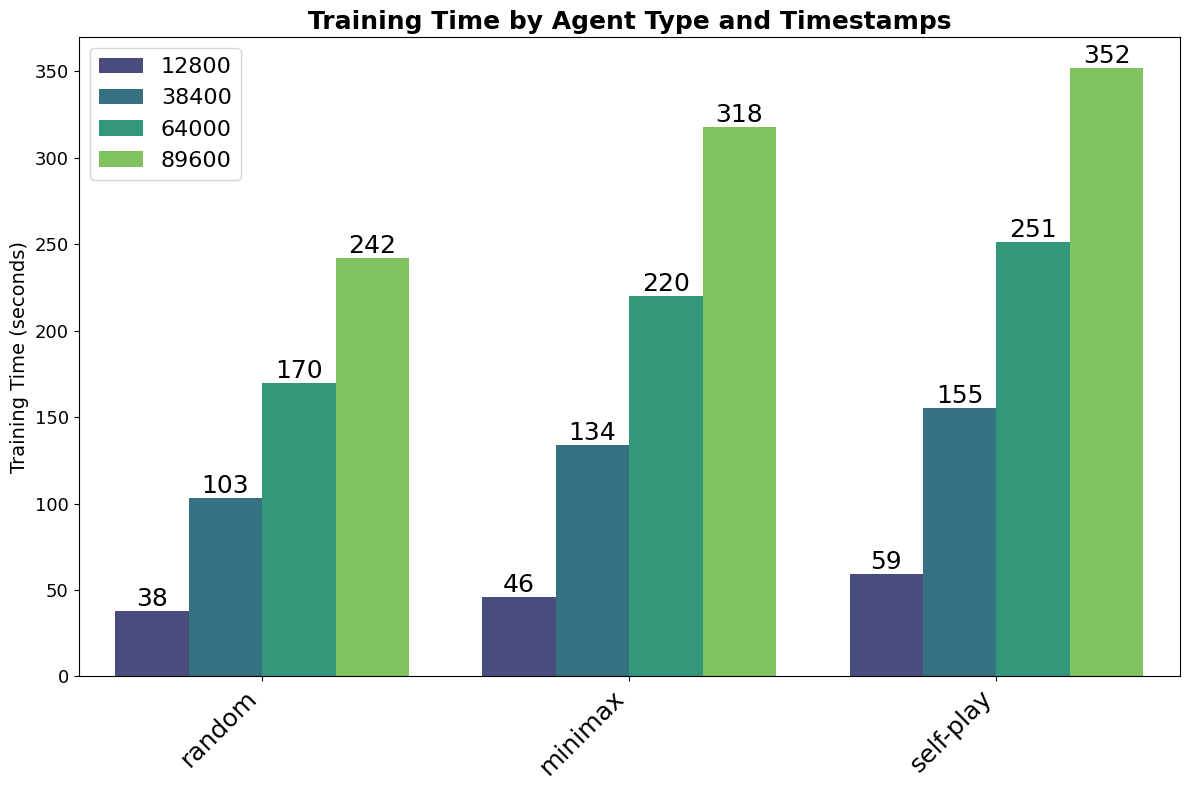

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [10]:
# LOAD table_runtime.csv file
df_runtime = pd.read_csv('table_runtime.csv')

# Rename 'Unnamed: 0' column to 'timestamps'
df_runtime = df_runtime.rename(columns={'Unnamed: 0': 'timestamps'})

# MELT THE DF INTO A LONG FORMAT AND CONVERT TIMESTAMPS TO STRINGS
df_melted = df_runtime.melt(id_vars=['timestamps'], var_name='Agent Type', value_name='Training Time (seconds)')
df_melted['timestamps'] = df_melted['timestamps'].astype(str)

# BAR PLOT
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_melted, x='Agent Type', y='Training Time (seconds)', hue='timestamps', palette='viridis')

# ADD LABELS TO EACH BAR
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=18) # Increased fontsize for bar labels

# TITLE + LABELS
plt.title('Training Time by Agent Type and Timestamps', fontsize=18,
          fontweight='bold')
plt.xlabel('', fontsize=14)
plt.ylabel('Training Time (seconds)', fontsize=14)

# INCREASE TICK LABEL FONT SIZE
ax.tick_params(axis='x', labelsize=18) # Increased fontsize for x-tick labels
ax.tick_params(axis='y', labelsize=13) # Increased fontsize for y-tick labels

# ROTATE x-AXIS LABEL FOR BETTER READABILITY
plt.xticks(rotation=45, ha='right')

# INCREASE LEGEND SIZE
ax.legend(fontsize=16)

# DISPLAY AND SAVE THE PLOT
plt.tight_layout()
plt.savefig('training_time_comparison_plot.png', dpi=300, bbox_inches='tight')
plt.show()